# Exploratory Data Analysis...
## Histograms of category click rates for each feature
### We're looking for features with well-sampled categories that show significant variation in click rate. We expect such features to be useful to help predict click rates in new data.
### Categories of a feature with high cardinality tend to be sparsely sampled, so variations in category click rate may not be significant. For this reason, we limit our attention to features with relatively low cardinality -- up to a few dozen or so categories.
### Unfortunately, it seems that click rates are too noisy to be of any use in prediction...


In [31]:

# Avazu competitition using pandas and sklearn library
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import category_encoders as ce
import copy
import pickle
import gc
#import xlearn as xl
%matplotlib inline
from datetime import datetime, date, time
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import log_loss
from sklearn.feature_extraction import FeatureHasher
from sklearn import preprocessing 
from sklearn.pipeline import Pipeline
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from xgboost import XGBClassifier #note: activate the xgboost environment
from lightgbm import LGBMClassifier


# set control parameters

important_columns = []

# set the number of hash bins
# 2**27 gets same result as 2**29, 2**30 produces memory error
n_features = 2**20
#n_features = 2**16

# method of handling categoricals: 'encode' or 'hash'
# categorical_method='encode'

# chunk_size
chunk_size= 1e5

# feature columns to drop
drop_columns = [[]]
drop_column = drop_columns[0]

# file and folder paths
train_file = 'train_shuffled.csv' #!!!!! no header
# train_file = 'train.csv'
model_path = './'

# number of training examples
n_rows = chunk_size

# seed for random generator
seed = 99

# option to archive model
archive_model = True

# set start time
start = datetime.now()

# column names in original data file
header = ['id','click','hour','C1','banner_pos','site_id','site_domain','site_category','app_id','app_domain','app_category','device_id',\
        'device_ip','device_model','device_type','device_conn_type','C14','C15','C16','C17','C18','C19','C20','C21']

# list of regularization hyperparameter values
# C_range = [1]

# select classifier
classifier = 'lgb'

# Option to tune the hyperparameters by cross-validation
cv_tune = False

#scale_pos_weight = sum(y_train==0)/sum(y_train==1)
scale_pos_weight = 1

# set model parameters
params = {}
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
# params['num_iterations'] = 100 # default
params['feature_fraction'] = 0.5
params['bagging_fraction'] = 0.5
params['bagging_freq'] = 1
params['num_threads'] = 4 # number of CPUs
params['is_unbalance'] = False
params['max_bin'] = n_features
params['importance_type'] = 'gain' 
#params['feature_name'] = 'auto' 
#params['categorical_feature'] = 'auto'
#params['n_estimators'] = 300
params['is_unbalance'] = False
params['scale_pos_weight'] = 1

# correction for unbalanced data only makes things worse!
# neg to pos class ratio

# fraction of training data to use 
train_frac = 0.8

# read data and preprocess
rawdata = pd.read_table(train_file, sep=',', chunksize=chunk_size, names=header,header=None,\
       nrows = n_rows).get_chunk()
#rawdata  = pd.read_table(train_file, sep=',', chunksize=chunk_size, names=None, header=0,\
#       nrows = n_rows).get_chunk()

# add hour and dayoftheweek features, drop 'id'
add_engineered_datetime_features = True
if(add_engineered_datetime_features): 
    print('adding engineered datetime features...')
    rawdata['hour']=rawdata['hour'].map(lambda x: datetime.strptime(str(x),"%y%m%d%H"))
    rawdata['dayoftheweek']=rawdata['hour'].map(lambda x:  x.weekday())
    rawdata['hour']=rawdata['hour'].map(lambda x:  x.hour)
rawdata.drop('id',axis=1,inplace=True)
# feature cardinalities
cardinality = {}
for col in rawdata.columns.tolist():
    cardinality[col]=len(rawdata[col].unique())
print(cardinality)



adding engineered datetime features...
{'click': 2, 'hour': 24, 'C1': 7, 'banner_pos': 7, 'site_id': 1445, 'site_domain': 1304, 'site_category': 18, 'app_id': 1276, 'app_domain': 91, 'app_category': 21, 'device_id': 17070, 'device_ip': 77873, 'device_model': 3123, 'device_type': 5, 'device_conn_type': 4, 'C14': 1735, 'C15': 8, 'C16': 9, 'C17': 399, 'C18': 4, 'C19': 63, 'C20': 155, 'C21': 60, 'dayoftheweek': 7}


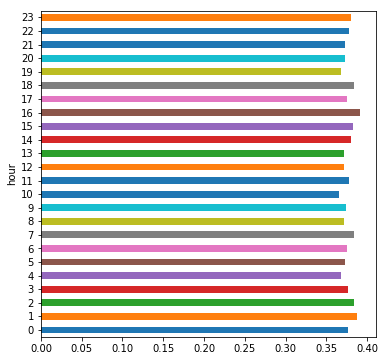

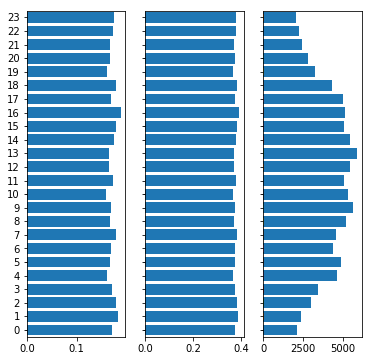

In [37]:
# mean click rate by hour -- not much variation,
# perhaps it can be mildly predictive
hs=rawdata.groupby('hour')['click'].mean()
hs.plot(kind='barh', figsize=(6,6))

# std dev of click rate by hour -- constant but very large!!
hs=rawdata.groupby('hour')['click'].std()
hs.plot(kind='barh', figsize=(6,6))


# CTR by hour is noisy!
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(6,6))

hs1=rawdata.groupby('hour')['click'].mean()
ax1.barh(hs1.index,hs1.values)

hs2=rawdata.groupby('hour')['click'].std()
ax2.barh(hs2.index,hs2.values)




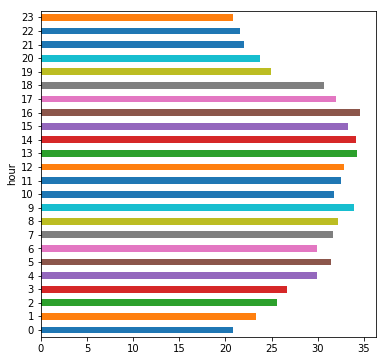

In [38]:
#SNR plot
hs3=rawdata.groupby('hour')['click'].count()
hs4 = (hs1/hs2)*np.sqrt(hs3)
hs4.plot(kind='barh', figsize=(6,6))


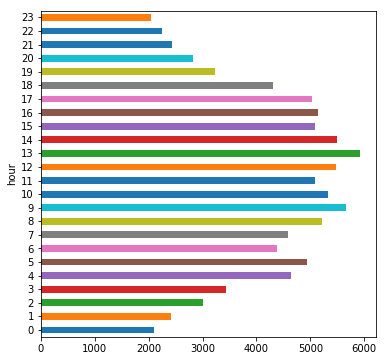

In [41]:
# number of impressions shown by hour
# is this solely determined by user actvity? 
# or is there a way the advertiser can control this?
# !!!!!predictive
hs=rawdata.groupby('hour')['click'].count()
hs.plot(kind='barh', figsize=(6,6))


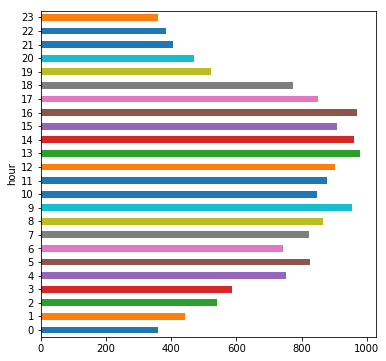

In [42]:
# click counts by hour -- as expected, correlates well with number of impressions shown
# should be predictive
hs=rawdata.groupby('hour')['click'].sum()
hs.plot(kind='barh', figsize=(6,6))


dayoftheweek
0    1537
1    3813
2    3527
3    3502
4    1483
5    1525
6    1716
Name: click, dtype: int64


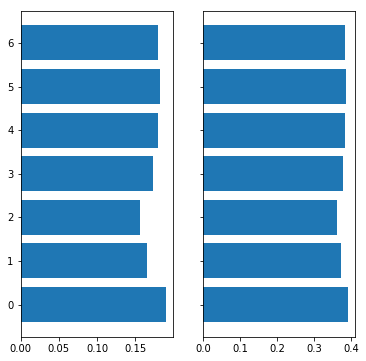

In [43]:
# dayofweek CTR is noisy
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(6,6))
hs1=rawdata.groupby('dayoftheweek')['click'].mean()
ax1.barh(hs1.index,hs1.values)
hs2=rawdata.groupby('dayoftheweek')['click'].std()
ax2.barh(hs2.index,hs2.values)


# click rate by dayoftheweek
#hs=rawdata.groupby('dayoftheweek')['click'].mean()
#hs.plot(kind='barh', figsize=(6,6))

# total clicks
print(rawdata.groupby('dayoftheweek')['click'].sum())


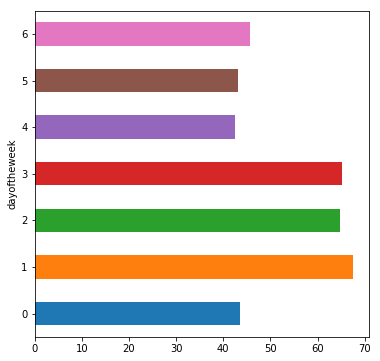

In [45]:
#SNR plot
hs3=rawdata.groupby('dayoftheweek')['click'].count()
hs4 = (hs1/hs2)*np.sqrt(hs3)
hs4.plot(kind='barh', figsize=(6,6))


C1
1001        0
1002     1180
1005    15660
1007        4
1008        1
1010      207
1012       51
Name: click, dtype: int64


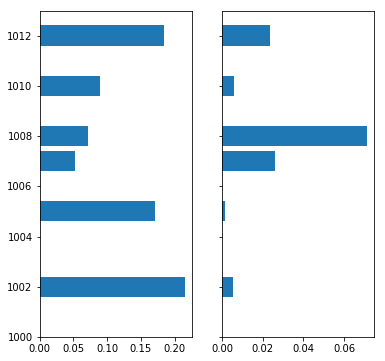

In [49]:
# C1 CTR is noisy
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(6,6))
hs1=rawdata.groupby('C1')['click'].mean()
ax1.barh(hs1.index,hs1.values)
hs2=rawdata.groupby('C1')['click'].std()
# Show "standard error" rather than "standard deviation"
hs2a = hs2/np.sqrt(rawdata.groupby('C1')['click'].count())
ax2.barh(hs2a.index,hs2a.values)


# click rate by C1 category
# to noisy to tell if it's predictive
#hs=rawdata.groupby('C1')['click'].mean()
#hs.plot(kind='barh', figsize=(6,6))
# total clicks
print(rawdata.groupby('C1')['click'].sum())


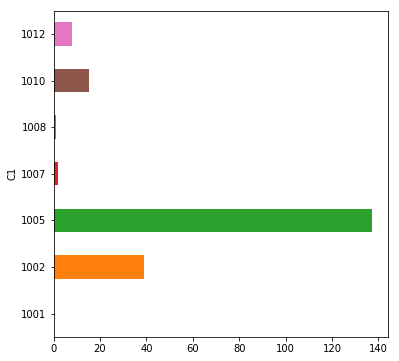

In [48]:
#SNR plot shows that 1002 and 1005 have very strong signals
hs3=rawdata.groupby('C1')['click'].count()
hs4 = (hs1/hs2)*np.sqrt(hs3)
hs4.plot(kind='barh', figsize=(6,6))


banner_pos
0    11933
1     5125
2        5
3        1
4        5
5        1
7       33
Name: click, dtype: int64


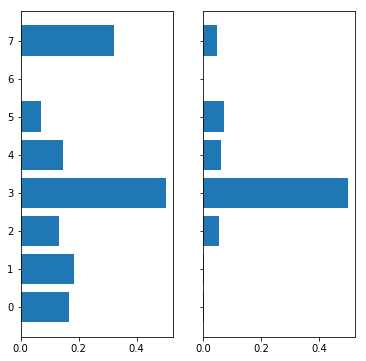

In [52]:
# bannerpos CTR is noisy
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(6,6))
hs1=rawdata.groupby('banner_pos')['click'].mean()
ax1.barh(hs1.index,hs1.values)
hs2=rawdata.groupby('banner_pos')['click'].std()
# Show "standard error" rather than "standard deviation"
hs2a = hs2/np.sqrt(rawdata.groupby('banner_pos')['click'].count())
ax2.barh(hs2a.index,hs2a.values)


# click rate by banner_pos
#hs=rawdata.groupby('banner_pos')['click'].mean()
#hs.plot(kind='barh', figsize=(6,6))
# total clicks
print(rawdata.groupby('banner_pos')['click'].sum())


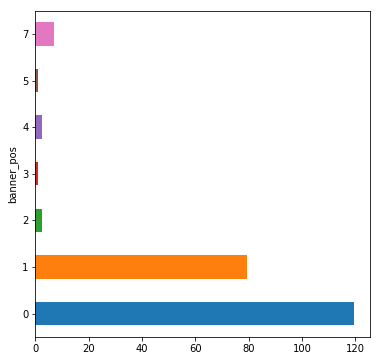

In [53]:
#SNR plot -- only positions 0 and 1 have strong signal
hs3=rawdata.groupby('banner_pos')['click'].count()
hs4 = (hs1/hs2)*np.sqrt(hs3)
hs4.plot(kind='barh', figsize=(6,6))


site_category
0569f928       1
28905ebd    3899
335d28a8      34
3e814130    2129
42a36e14       0
50e219e0    5263
5378d028       0
70fb0e29      12
72722551       5
75fa27f6      44
76b2941d       5
8fd0aea4       1
a818d37a       0
bcf865d9       0
c0dd3be3      11
dedf689d      30
f028772b    5651
f66779e6      18
Name: click, dtype: int64


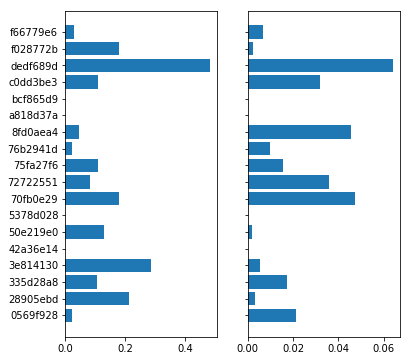

In [55]:
# site_category CTR is noisy
attr = 'site_category'
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(6,6))
hs1=rawdata.groupby(attr)['click'].mean()
ax1.barh(hs1.index,hs1.values)
hs2=rawdata.groupby(attr)['click'].std()
# Show "standard error" rather than "standard deviation"
hs2a = hs2/np.sqrt(rawdata.groupby('site_category')['click'].count())
ax2.barh(hs2a.index,hs2a.values)


# click rate by site_category
#hs=rawdata.groupby('site_category')['click'].mean()
#hs.plot(kind='barh', figsize=(6,6))
# total clicks
print(rawdata.groupby('site_category')['click'].sum())


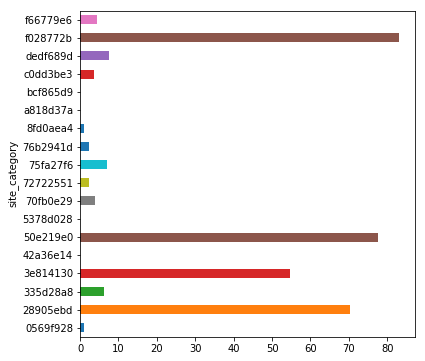

In [56]:
#SNR plot
hs3=rawdata.groupby('site_category')['click'].count()
hs4 = (hs1/hs2)*np.sqrt(hs3)
hs4.plot(kind='barh', figsize=(6,6))


app_category
07d7df22    13029
09481d60       19
0bfbc358        0
0f2161f8     2576
0f9a328c        0
18b1e0be        0
2281a340        0
2fc4f2aa        1
4681bb9d        2
4ce2e9fc        6
75d80bbe        9
879c24eb        3
8ded1f7a      329
8df2e842        1
a3c42688        0
a86a3e89        0
cef3e649      420
d1327cf5       17
dc97ec06       19
f95efa07      667
fc6fa53d        5
Name: click, dtype: int64


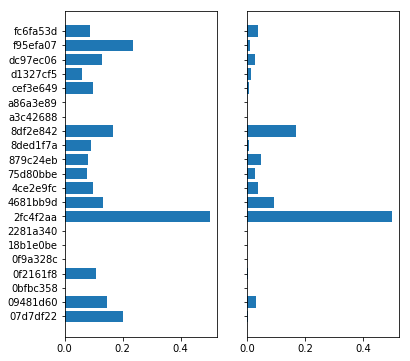

In [57]:
# app_category CTR is noisy
attr = 'app_category'
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(6,6))
hs1=rawdata.groupby(attr)['click'].mean()
ax1.barh(hs1.index,hs1.values)
hs2=rawdata.groupby(attr)['click'].std()
# Show "standard error" rather than "standard deviation"
hs2a = hs2/np.sqrt(rawdata.groupby('app_category')['click'].count())
ax2.barh(hs2a.index,hs2a.values)


# click rate by app_category
#hs=rawdata.groupby('app_category')['click'].mean()
#hs.plot(kind='barh', figsize=(6,6))
# total clicks
print(rawdata.groupby('app_category')['click'].sum())


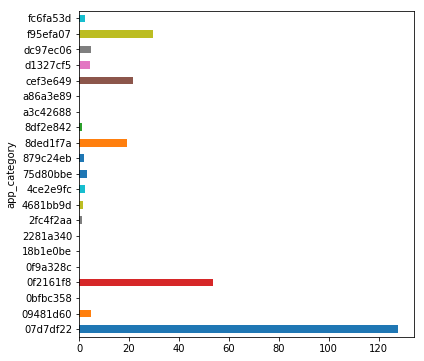

In [58]:
#SNR plot -- there are certain app categories that are strongly predictive, 
#    because their click rates differ by a statistically significant amount
hs3=rawdata.groupby('app_category')['click'].count()
hs4 = (hs1/hs2)*np.sqrt(hs3)
hs4.plot(kind='barh', figsize=(6,6))


device_type
0     1180
1    15715
2        1
4      178
5       29
Name: click, dtype: int64


<BarContainer object of 5 artists>

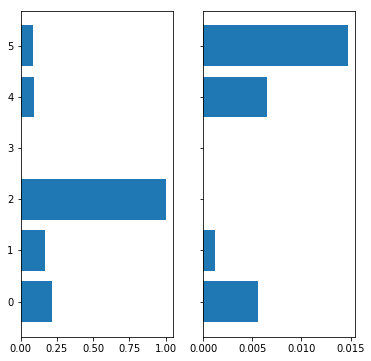

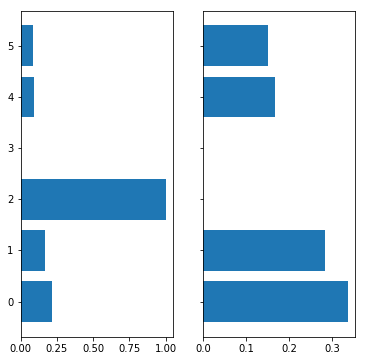

In [59]:
# device_type CTR is noisy
attr = 'device_type'
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(6,6))
hs1=rawdata.groupby(attr)['click'].mean()
ax1.barh(hs1.index,hs1.values)
hs2=rawdata.groupby(attr)['click'].std()
# Show "standard error" rather than "standard deviation"
hs2a = hs2/np.sqrt(rawdata.groupby('device_type')['click'].count())
ax2.barh(hs2a.index,hs2a.values)


# click rate by device_type
#hs=rawdata.groupby('device_type')['click'].mean()
#hs.plot(kind='barh', figsize=(6,6))
# total clicks
print(rawdata.groupby('device_type')['click'].sum())

# device_type CTR is noisy
attr = 'device_type'
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(6,6))
hs1=rawdata.groupby(attr)['click'].mean()
ax1.barh(hs1.index,hs1.values)
hs2=rawdata.groupby(attr)['click'].mad()
ax2.barh(hs2.index,hs2.values)


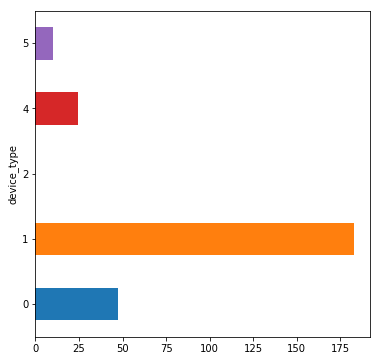

In [60]:
#SNR plot -- categories 0 and 1 strongly predictive, 
#    because their click rates differ by a statistically significant amount
hs3=rawdata.groupby('device_type')['click'].count()
hs4 = (hs1/hs2)*np.sqrt(hs3)
hs4.plot(kind='barh', figsize=(6,6))


device_conn_type
0    15787
2     1069
3      245
5        2
Name: click, dtype: int64


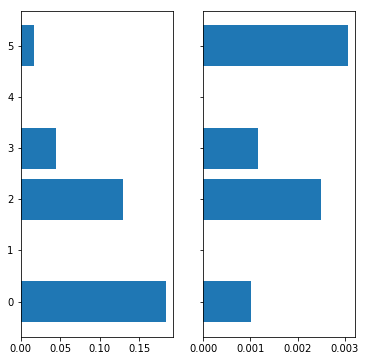

In [61]:
# device_conn_type CTR is noisy
attr = 'device_conn_type'
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(6,6))
hs1=rawdata.groupby(attr)['click'].mean()
ax1.barh(hs1.index,hs1.values)
hs2=rawdata.groupby(attr)['click'].mad()
# Show "standard error" rather than "standard deviation"
hs2a = hs2/np.sqrt(rawdata.groupby('device_conn_type')['click'].count())
ax2.barh(hs2a.index,hs2a.values)


# click rate by device_conn_type
#hs=rawdata.groupby('device_conn_type')['click'].mean()
#hs.plot(kind='barh', figsize=(6,6))
# total clicks
print(rawdata.groupby('device_conn_type')['click'].sum())


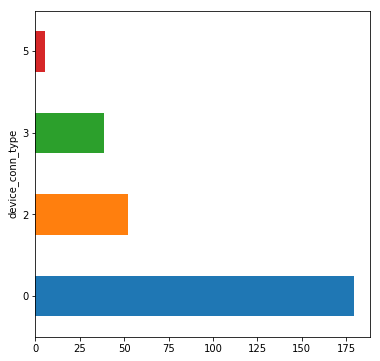

In [62]:
#SNR plot -- categories 0, 2 and 3 are strongly predictive, 
#    because their click rates differ by a statistically significant amount
hs3=rawdata.groupby('device_conn_type')['click'].count()
hs4 = (hs1/hs2)*np.sqrt(hs3)
hs4.plot(kind='barh', figsize=(6,6))


C14
375       24
377       20
380       17
381        5
452       12
454        6
456        4
463        8
787        2
1037       2
1038       2
1039       2
1266       1
1267       5
1268       6
1269       3
1270       4
1272       5
1275       8
1276      12
1278       7
4407       2
4518       1
4687     134
6360       5
6361       1
6362       1
6364       6
6365      10
6366       5
        ... 
21674      3
21675      5
21676      3
21677      4
21678      7
21679      3
21680     12
21681      6
21682      4
21683     13
21684      5
21685     11
21687      5
21688      6
21689      8
21691      8
21692      0
21693      1
21694      0
21695      0
21696      0
21697      0
21698      1
21699      0
21700      2
21701      1
21702      0
21703      0
21704      1
21705      0
Name: click, Length: 420, dtype: int64


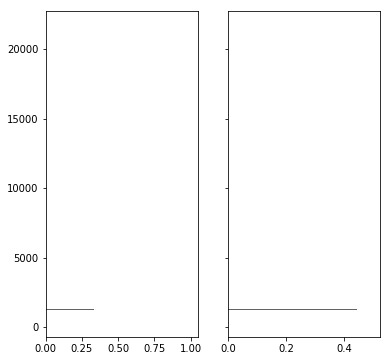

In [24]:
#!!!!! figure out how to display y-axis as category names, not numbers
# C14 CTR is noisy
attr = 'C14'
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(6,6))
hs1=rawdata.groupby(attr)['click'].mean()
ax1.barh(hs1.index,hs1.values)
hs2=rawdata.groupby(attr)['click'].mad()
ax2.barh(hs2.index,hs2.values)


# click rate by C14
#hs=rawdata.groupby('C14')['click'].mean()
#hs.plot(kind='barh', figsize=(6,6))
# total clicks
print(rawdata.groupby('C14')['click'].sum())


C15
120     0.000000
216     0.115438
300     0.358908
320     0.160015
480     0.333333
728     0.037559
768     0.000000
1024    0.750000
Name: click, dtype: float64 C15
120     0.000000
216     0.011925
300     0.006285
320     0.001201
480     0.210819
728     0.013058
768     0.000000
1024    0.250000
Name: click, dtype: float64
C15
120         0
216        83
300      2091
320     14916
480         2
728         8
768         0
1024        3
Name: click, dtype: int64


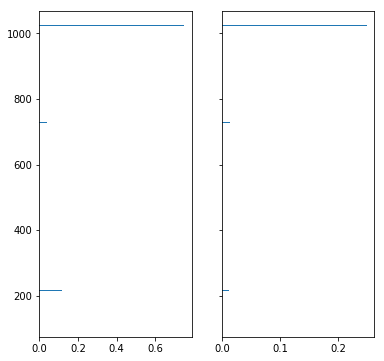

In [66]:
#!!!!! figure out how to display y-axis as category names, not numbers
# C15 CTR is noisy
attr = 'C15'
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(6,6))
hs1=rawdata.groupby(attr)['click'].mean()
ax1.barh(hs1.index,hs1.values)
hs2=rawdata.groupby(attr)['click'].std()
# Show "standard error" rather than "standard deviation"
hs2a = hs2/np.sqrt(rawdata.groupby('C15')['click'].count())
ax2.barh(hs2a.index,hs2a.values)
print(hs1,hs2a)

# click rate by C15
#hs=rawdata.groupby('C15')['click'].mean()
#hs.plot(kind='barh', figsize=(6,6))
# total clicks
print(rawdata.groupby('C15')['click'].sum())


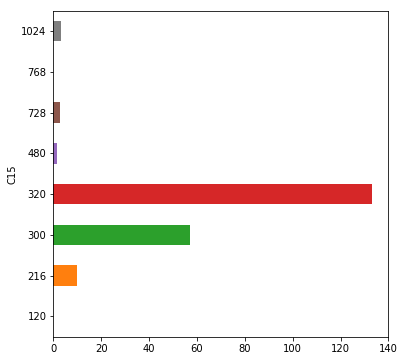

In [65]:
#SNR plot -- categories 300 and 320 are strongly predictive, 
#    because their click rates differ by a statistically significant amount
hs3=rawdata.groupby('C15')['click'].count()
hs4 = (hs1/hs2)*np.sqrt(hs3)
hs4.plot(kind='barh', figsize=(6,6))


C16
20         12
36        719
50      94395
90        213
250      4393
320         6
480       254
768         4
1024        4
Name: click, dtype: int64
C16
20      0.000000
36      0.115438
50      0.159701
90      0.037559
250     0.428864
320     0.333333
480     0.188976
768     0.750000
1024    0.000000
Name: click, dtype: float64
C16
20      0.000000
36      0.011925
50      0.001192
90      0.013058
250     0.007468
320     0.210819
480     0.024613
768     0.250000
1024    0.000000
Name: click, dtype: float64


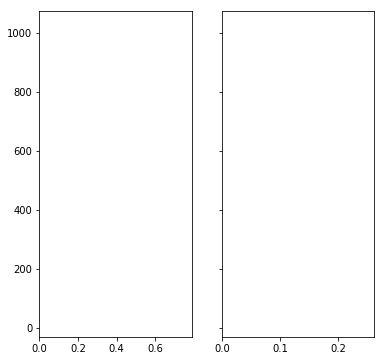

In [74]:
#!!!!! figure out how to display y-axis as category names, not numbers
# C16 CTR is noisy
attr = 'C16'
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(6,6))
hs1=rawdata.groupby(attr)['click'].mean()
ax1.barh(hs1.index,hs1.values)
hs2=rawdata.groupby(attr)['click'].std()
# Show "standard error" rather than "standard deviation"
hs2a = hs2/np.sqrt(rawdata.groupby('C16')['click'].count())
ax2.barh(hs2a.index,hs2a.values)


# C16
#hs=rawdata.groupby('C16')['click'].mean()
#hs.plot(kind='barh', figsize=(6,6))
# total clicks
print(rawdata.groupby('C16')['click'].count())
print(rawdata.groupby('C16')['click'].mean())
print(hs2a)

In [ ]:
#SNR plot -- categories 50 and 250 are strongly predictive, 
#    because their click rates differ by a statistically significant amount
hs3=rawdata.groupby('C16')['click'].count()
hs4 = (hs1/hs2)*np.sqrt(hs3)
hs4.plot(kind='barh', figsize=(6,6))


C17
112      66
122      30
153       2
178       6
196      51
394       3
423     134
544      28
547       9
549       6
550       1
571     100
572      42
576     128
613      19
686       0
768       0
827       2
898       2
901       0
906       3
937       2
1092     16
1248     97
1255      0
1272     11
1401      7
1447      6
1507      2
1528      2
       ... 
2351     61
2371     93
2372     35
2374    511
2390      1
2394      0
2397      0
2424      3
2425      1
2427      8
2434     22
2438      1
2443     12
2446    292
2449     32
2459      0
2465      0
2467     13
2471     11
2476      2
2478      4
2480    134
2481     12
2482      0
2483      0
2485      8
2493    188
2495     38
2496     65
2497      6
Name: click, Length: 128, dtype: int64


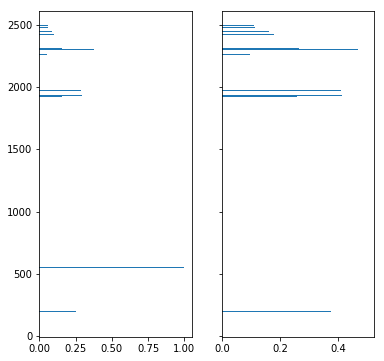

In [26]:
#!!!!! figure out how to display y-axis as category names, not numbers
# C17 CTR is noisy
attr = 'C17'
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(6,6))
hs1=rawdata.groupby(attr)['click'].mean()
ax1.barh(hs1.index,hs1.values)
hs2=rawdata.groupby(attr)['click'].mad()
ax2.barh(hs2.index,hs2.values)


# click rate by C17
#hs=rawdata.groupby('C17')['click'].mean()
#hs.plot(kind='barh', figsize=(6,6))
# total clicks
print(rawdata.groupby('C17')['click'].sum())


C18
0    6599
1     222
2    5247
3    5035
Name: click, dtype: int64


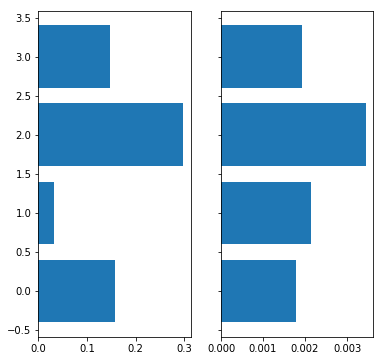

In [77]:
# C18 CTR is noisy
attr = 'C18'
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(6,6))
hs1=rawdata.groupby(attr)['click'].mean()
ax1.barh(hs1.index,hs1.values)
hs2=rawdata.groupby(attr)['click'].std()
# Show "standard error" rather than "standard deviation"
hs2a = hs2/np.sqrt(rawdata.groupby('C18')['click'].count())
ax2.barh(hs2a.index,hs2a.values)


# click rate by C18
#hs=rawdata.groupby('C18')['click'].mean()
#hs.plot(kind='barh', figsize=(6,6))
# total clicks
print(rawdata.groupby('C18')['click'].sum())

C18
0    88.554330
1    15.146770
2    86.486792
3    76.883817
Name: click, dtype: float64


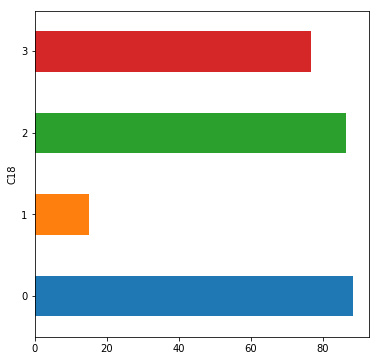

In [78]:
#SNR plot -- categories 0, 2, 3 are strongly predictive, 
#    because their click rates differ by a statistically significant amount
hs3=rawdata.groupby('C18')['click'].count()
hs4 = (hs1/hs2)*np.sqrt(hs3)
hs4.plot(kind='barh', figsize=(6,6))
print(hs4)

C19
33         0
35      9156
39      4242
41         7
43        14
47        78
161       30
163      169
167      352
169       10
171      297
175       25
291        2
297      177
303      623
423        3
425        2
427       58
431      267
551       93
559        2
673        3
679        2
681       42
683        7
687      306
801        4
813       35
943        7
1063    1295
1071       2
1315       0
1319      96
1327       6
1451       3
1711      59
1835      16
Name: click, dtype: int64


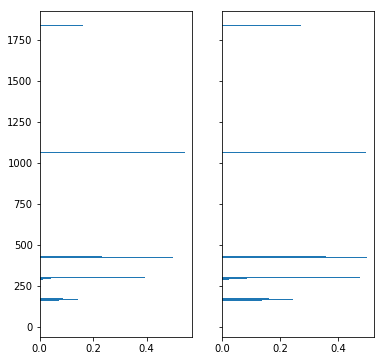

In [27]:
#!!!!! figure out how to display y-axis as category names, not numbers
# C19 CTR is noisy
attr = 'C19'
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(6,6))
hs1=rawdata.groupby(attr)['click'].mean()
ax1.barh(hs1.index,hs1.values)
hs2=rawdata.groupby(attr)['click'].mad()
ax2.barh(hs2.index,hs2.values)


# click rate by C19
#hs=rawdata.groupby('C19')['click'].mean()
#hs.plot(kind='barh', figsize=(6,6))
# total clicks
print(rawdata.groupby('C19')['click'].sum())


C20
-1         10982
 100000       60
 100001        2
 100002        4
 100003        1
 100004        0
 100005        2
 100010        0
 100012        0
 100013        6
 100016        0
 100019       18
 100020       34
 100021       18
 100022        2
 100024        0
 100025        2
 100026        3
 100028       42
 100029        0
 100034      136
 100037        4
 100039        8
 100040        2
 100041        1
 100043        1
 100046       29
 100048       30
 100049       15
 100050       32
           ...  
 100176       10
 100177        2
 100183        3
 100185        0
 100188       15
 100189        7
 100190        0
 100191       37
 100192        3
 100193        5
 100194       33
 100195        1
 100199       12
 100200       20
 100202       11
 100205        5
 100206        8
 100210       38
 100212        2
 100213        1
 100215       20
 100217       54
 100221        8
 100224        4
 100225        3
 100228      293
 100229        1
 100233   

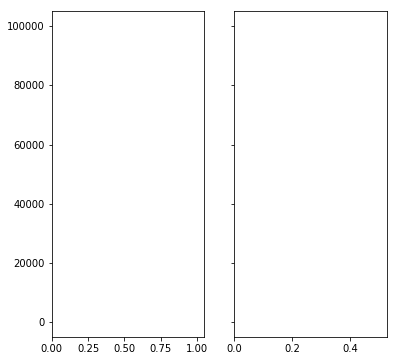

In [28]:
#!!!!! figure out how to display y-axis as category names, not numbers
# C20 CTR is noisy
attr = 'C20'
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(6,6))
hs1=rawdata.groupby(attr)['click'].mean()
ax1.barh(hs1.index,hs1.values)
hs2=rawdata.groupby(attr)['click'].mad()
ax2.barh(hs2.index,hs2.values)


# click rate by C20
#hs=rawdata.groupby('C20')['click'].mean()
#hs.plot(kind='barh', figsize=(6,6))
# total clicks
print(rawdata.groupby('C20')['click'].sum())


C21
13      157
15      167
16      198
20        2
23     1649
32      694
33     2526
42       17
46      128
48      374
52      561
61      321
68        1
70        2
71       21
79     7651
82       31
85        0
91       73
93        8
94        7
95       52
100       7
101      45
111       2
116       0
117     447
156     313
157    2036
Name: click, dtype: int64


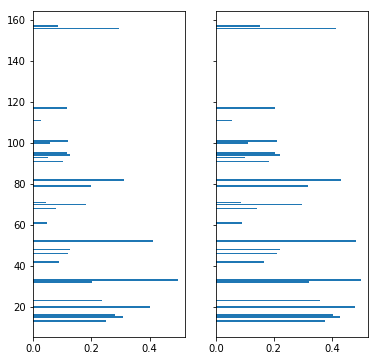

In [29]:
#!!!!! figure out how to display y-axis as category names, not numbers
# C21 CTR is noisy
attr = 'C21'
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(6,6))
hs1=rawdata.groupby(attr)['click'].mean()
ax1.barh(hs1.index,hs1.values)
hs2=rawdata.groupby(attr)['click'].mad()
ax2.barh(hs2.index,hs2.values)


# click rate by C21
#hs=rawdata.groupby('C21')['click'].mean()
#hs.plot(kind='barh', figsize=(6,6))
# total clicks
print(rawdata.groupby('C21')['click'].sum())


dayoftheweek
0    1537
1    3813
2    3527
3    3502
4    1483
5    1525
6    1716
Name: click, dtype: int64


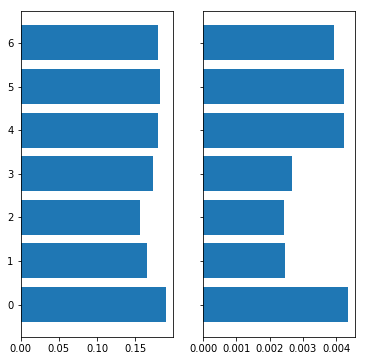

In [68]:
#!!!!! figure out how to display y-axis as category names, not numbers
# dayoftheweek CTR is noisy
attr = 'dayoftheweek'
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(6,6))
hs1=rawdata.groupby(attr)['click'].mean()
ax1.barh(hs1.index,hs1.values)
hs2=rawdata.groupby(attr)['click'].std()
# Show "standard error" rather than "standard deviation"
hs2a = hs2/np.sqrt(rawdata.groupby('dayoftheweek')['click'].count())
ax2.barh(hs2a.index,hs2a.values)


# click rate by dayoftheweek
#hs=rawdata.groupby('dayoftheweek')['click'].mean()
#hs.plot(kind='barh', figsize=(6,6))
# total clicks
print(rawdata.groupby('dayoftheweek')['click'].sum())


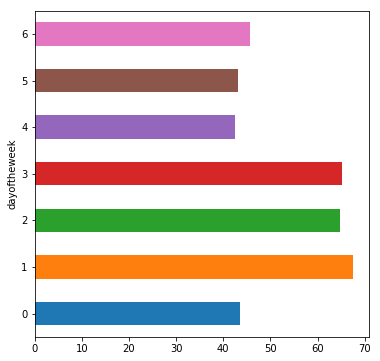

In [70]:
# SNR plot -- all the categories are predictive, 
# because their click rates differ by a statistically significant amount
hs3=rawdata.groupby('dayoftheweek')['click'].count()
hs4 = (hs1/hs2)*np.sqrt(hs3)
hs4.plot(kind='barh', figsize=(6,6))
